In [ ]:
!pip install -U adapter-transformers
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
from transformers import BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, BertConfig
from transformers import RobertaTokenizer, RobertaConfig, RobertaModelWithHeads
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
import time
import datetime
import random
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Preparing

dataset = load_dataset("humarin/chatgpt-paraphrases")

# 將資料分成0和1
category={}
# for i in range(len(data)):
for i in range(0, 20000):
#     chatgpt=data.iloc[i]["paraphrases"][:].split(', ')
#     for j in chatgpt:
#         category[j[1:-1]]='chatgpt'
    category[dataset['train'][i]["paraphrases"][:].split(', ')[0][2:-1]]=1
    category[dataset['train'][i]['text']]=0
    # category[dataset.iloc(i)["paraphrases"][:].split(', ')[0][2:-1]]=1
    # category[dataset.iloc(i)['text']]=0

data=pd.DataFrame(category.items(),columns=["text","label"])
data=data.sample(frac=1)

print(data["label"].value_counts())


0    19998
1    19757
Name: label, dtype: int64


In [ ]:
# for i in range(0,10):
#   print(data.values[i])

In [ ]:
# train_size = int(0.9 * len(data))
# val_size = len(data) - train_size


train_df, validation_df = train_test_split(data, test_size=0.1)

train_dataset = Dataset.from_dict(train_df)
validation_dataset = Dataset.from_dict(validation_df)
dataset = datasets.DatasetDict({"train":train_dataset,"validation":validation_dataset})
# print(dataset)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=80, truncation=True, padding="max_length")

# Encode the input data
dataset = dataset.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset = dataset.rename_column("label", "labels")
# Transform to pytorch tensors and only output the required columns
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

Map:   0%|          | 0/35779 [00:00<?, ? examples/s]

Map:   0%|          | 0/3976 [00:00<?, ? examples/s]

In [ ]:
# train
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=2,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/roberta/adapter_model.py:274: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new clas

Every dataset sample has an input text and a binary label:

In [ ]:
# Add a new adapter
model.add_adapter("rotten_tomatoes")
# Add a matching classification head
model.add_classification_head(
    "rotten_tomatoes",
    num_labels=2
  )
# Activate the adapter
model.train_adapter("rotten_tomatoes")

# model.cuda()

Adding adapter 'rotten_tomatoes'.
Adding head 'rotten_tomatoes' with config {'head_type': 'classification', 'num_labels': 2, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1}, 'use_pooler': False, 'bias': True}.


In [ ]:
import numpy as np
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./drive/MyDrive/model",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Start the training 🚀

In [ ]:
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 35779
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6714
  Number of trainable parameters = 1486658


Step,Training Loss
200,0.584300
400,0.360200
600,0.342900
800,0.329400
1000,0.295800
1200,0.291800
1400,0.281200
1600,0.284800
1800,0.266700
2000,0.285400


Saving model checkpoint to ./drive/MyDrive/model/checkpoint-500
Configuration saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/adapter_config.json
Module weights saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/pytorch_model_head.bin
Configuration saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/checkpoint-500/rotten_tomatoes/pytorch_model_head.bin
Saving model checkpoint to ./drive/MyDrive/model/checkpoint-1000
Configuration saved in ./drive/MyDrive/model/checkpoint-1000/rotten_tomatoes/adapter_config.json
Module weights saved in ./drive/MyDrive/model/checkpoint-1000/rotten_tomatoes/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/checkpoint-1000/rotten_tomatoes/head_config.json
Mod

TrainOutput(global_step=6714, training_loss=0.25724136470718545, metrics={'train_runtime': 1912.7129, 'train_samples_per_second': 112.235, 'train_steps_per_second': 3.51, 'total_flos': 8978516789040000.0, 'train_loss': 0.25724136470718545, 'epoch': 6.0})

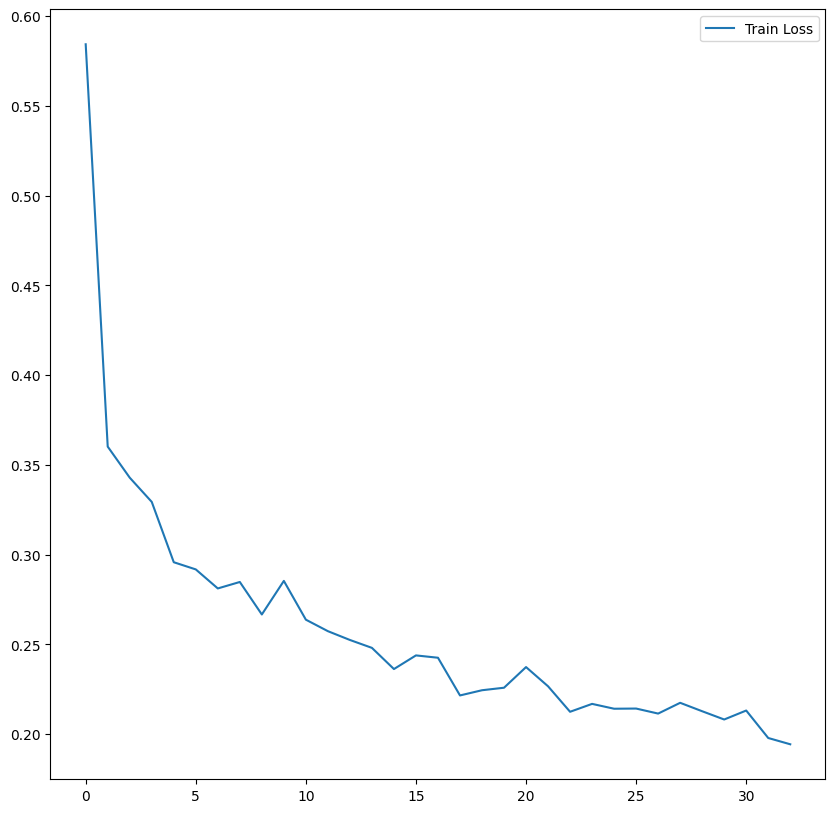

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.state.log_history
x = list(range(0, len(losses)-1))
plt_train_loss = []


for loss in losses:
  if 'loss' in loss:
    plt_train_loss.append(loss['loss'])


fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(x, plt_train_loss)
ax.legend(['Train Loss'])

Looks good! Let's evaluate our adapter on the validation split of the dataset to see how well it learned:

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3976
  Batch size = 32


{'eval_loss': 0.25277870893478394,
 'eval_acc': 0.9024144869215291,
 'eval_runtime': 17.6985,
 'eval_samples_per_second': 224.652,
 'eval_steps_per_second': 7.063,
 'epoch': 6.0}

We can put our trained model into a `transformers` pipeline to be able to make new predictions conveniently:

In [ ]:
losses = trainer.state.log_history
x = list(range(0, len(losses)-2))
plt_validation_loss = []


for loss in losses:
  print(loss)
#   if 'loss' in loss:
#     plt_validation_loss.append(loss['loss'])


# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(x, plt_train_loss)
# ax.legend(['validation Loss'])

{'loss': 0.5843, 'learning_rate': 9.702114983616324e-05, 'epoch': 0.18, 'step': 200}
{'loss': 0.3602, 'learning_rate': 9.404229967232648e-05, 'epoch': 0.36, 'step': 400}
{'loss': 0.3429, 'learning_rate': 9.106344950848973e-05, 'epoch': 0.54, 'step': 600}
{'loss': 0.3294, 'learning_rate': 8.808459934465296e-05, 'epoch': 0.71, 'step': 800}
{'loss': 0.2958, 'learning_rate': 8.510574918081621e-05, 'epoch': 0.89, 'step': 1000}
{'loss': 0.2918, 'learning_rate': 8.212689901697945e-05, 'epoch': 1.07, 'step': 1200}
{'loss': 0.2812, 'learning_rate': 7.914804885314269e-05, 'epoch': 1.25, 'step': 1400}
{'loss': 0.2848, 'learning_rate': 7.616919868930593e-05, 'epoch': 1.43, 'step': 1600}
{'loss': 0.2667, 'learning_rate': 7.319034852546918e-05, 'epoch': 1.61, 'step': 1800}
{'loss': 0.2854, 'learning_rate': 7.021149836163241e-05, 'epoch': 1.79, 'step': 2000}
{'loss': 0.2638, 'learning_rate': 6.723264819779566e-05, 'epoch': 1.97, 'step': 2200}
{'loss': 0.2574, 'learning_rate': 6.425379803395888e-05, '

In [ ]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)

classifier("What role do you think individual actions play in contributing to efforts to combat global warming and promote environmental sustainability?")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'EsmForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification', 'GPT2ForSequenceClassification', 'GPTNeoForSequenceClassification', 'GPTJForSequenceClassification', 'IBertForSequenceClassification', 'LayoutLMForSequenceClassification'

[{'label': 'LABEL_1', 'score': 0.9961013793945312}]

At last, we can also extract the adapter from our model and separately save it for later reuse. Note the size difference compared to a full model!

In [ ]:
model.save_adapter("./drive/MyDrive/model", "rotten_tomatoes")

!ls -lh final_adapter

Configuration saved in ./drive/MyDrive/model/adapter_config.json
Module weights saved in ./drive/MyDrive/model/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/head_config.json
Module weights saved in ./drive/MyDrive/model/pytorch_model_head.bin


ls: cannot access 'final_adapter': No such file or directory


**Share your work!**

The next step after training is to share our adapter with the world via _AdapterHub_. [Read our guide](https://docs.adapterhub.ml/contributing.html) on how to prepare the adapter module we just saved and contribute it to the Hub!

➡️ Also continue with [the next Colab notebook](https://colab.research.google.com/github/Adapter-Hub/adapter-transformers/blob/master/notebooks/02_Adapter_Inference.ipynb) to learn how to use adapters from the Hub.